<a href="https://colab.research.google.com/github/jdasam/mas1004/blob/2024/live_coding/3_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification
- In this notebook, we will practice binary classification using 2D inputs

In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(sci_mode=False) # to print 1e-04 as 0.0001

## 1. Generate Dataset

### 1-1 XOR Gate
- XOR Gate is true when the two inputs are different and false when the two inputs are same
  - XOR(False, False) = False
  - XOR(False, True) = True
  - XOR(True, False) = True
  - XOR(True, True) = False
- In this example, we will use x > 0 as True
  
  
  


[False  True  True False False False False]
[False False  True  True  True  True False]
[False  True  True  True  True  True False]
[False False  True False False False False]
[False  True False  True  True  True False]


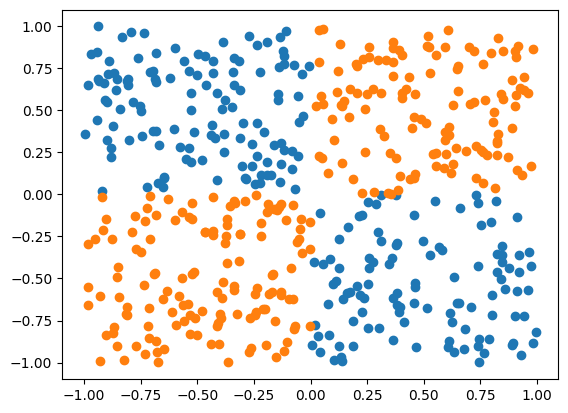

In [4]:
# make XOR gate dataset
N = 500
data = np.random.uniform(-1, 1, (N, 2))

label = np.zeros(500)
x_is_larger_than_zero = data[:, 0] > 0
y_is_larger_than_zero = data[:, 1] > 0
or_result = x_is_larger_than_zero | y_is_larger_than_zero
and_result = x_is_larger_than_zero & y_is_larger_than_zero
xor_result = np.bool_(np.int8(or_result) - np.int8(and_result))

# print(label)
# plt.scatter(x=data[:, 0], y=data[:,1])

print(x_is_larger_than_zero[:7])
print(y_is_larger_than_zero[:7])
print((x_is_larger_than_zero | y_is_larger_than_zero)[:7])
print(and_result[:7])
print(xor_result[:7])

data = torch.from_numpy(data).float()
label = torch.from_numpy(xor_result).float().unsqueeze(1)

plt.scatter(x=data[xor_result, 0], y=data[xor_result,1])
plt.scatter(x=data[~xor_result, 0], y=data[~xor_result,1])

### 1-2 Spiral Data
- This is another example of 2D binary classification

torch.Size([1000, 2]) torch.Size([1000, 1])


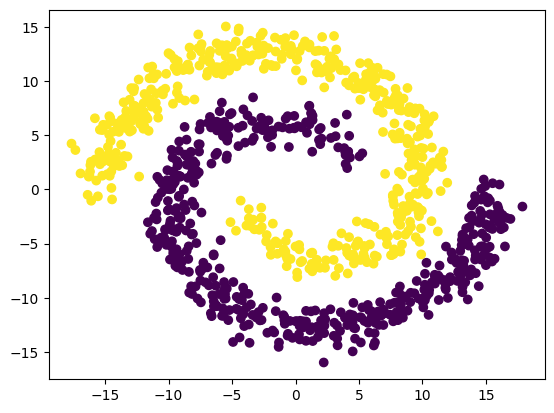

In [48]:

# make spiral data
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 500
noise_weight = 1.0
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
data_a = data_a + np.random.randn(N,2) * noise_weight

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
data_b = data_b + np.random.randn(N,2) * noise_weight

data = np.append(data_a, data_b, axis=0)
label = np.append(np.zeros(N), np.ones(N))

randomize_order = np.random.permutation(len(data))
data = data[randomize_order] # shuffle
label = label[randomize_order] # shuffle label with same order

data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float().unsqueeze(1)


print(data.shape, label.shape)
plt.scatter(data[:,0], data[:,1], c=label)

In [10]:
# Function for visualizing decision boundary of the model
def visualize_decision_boundary(model, data, label):
  x_linspace = torch.linspace(min(data[:,0]), max(data[:,0]), steps=200)
  y_linspace = torch.linspace(min(data[:,1]), max(data[:,1]), steps=200)
  grid_x, grid_y = torch.meshgrid(x_linspace, y_linspace)
  grid_xy = torch.stack([grid_x, grid_y]).permute(1,2,0)
  grid_xy = grid_xy.view(-1, 2)
  value_by_grid = model(grid_xy)
  value_by_grid = value_by_grid.view(200, 200, 1)
  value_by_grid[value_by_grid<=0.5] = 0
  value_by_grid[value_by_grid>0.5] = 1

  plt.scatter(x=data[label[:,0]==0,0], y=data[label[:,0]==0,1])
  plt.scatter(x=data[label[:,0]==1,0], y=data[label[:,0]==1,1])

  plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), value_by_grid.detach().numpy().squeeze(), alpha=0.3)

## 2. Inspect Dataset

In [28]:
data[:10]

tensor([[-0.1558, -0.0175],
        [ 0.3860,  0.9269],
        [ 0.8174, -0.9252],
        [-0.0834,  0.7413],
        [-0.1295, -0.0935],
        [-0.6539,  0.0572],
        [-0.2922,  0.1726],
        [ 0.2507, -0.7704],
        [ 0.0027,  0.5246],
        [ 0.8884,  0.4032]])

In [30]:
data[:10, 0] # get the x_position value of every sample

tensor([-0.1558,  0.3860,  0.8174, -0.0834, -0.1295, -0.6539, -0.2922,  0.2507,
         0.0027,  0.8884])

In [32]:
label[:10]

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]])

# 3. Define Model

In [61]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self, input_dim=2, hidden_size=32):
    super().__init__() # initialize its superclass, nn.Module
    self.layer1 = nn.Linear(input_dim, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = self.layer1(x)
    x = x.relu()
    x = self.layer2(x)
    x = x.relu()
    x = self.layer3(x)
    return x


model = Classifier()
logit = model(data) # logit is value before sigmoid
prob = logit.sigmoid()

# apply square loss
loss = (prob - label) ** 2
loss = loss.mean()
loss


tensor(0.3412, grad_fn=<MeanBackward0>)

In [53]:
# tqdm helps to visualize the progress bar in iteration
from tqdm.auto import tqdm

model = Classifier()
optimizer = torch.optim.Adam(model.parameters())

num_iter = 1000
loss_record = []

for iter in tqdm(range(num_iter)):
  logit = model(data) # logit is value before sigmoid
  prob = logit.sigmoid()
  # loss = (prob - label) ** 2 # square error
  # loss = loss.mean()
  loss = get_binary_cross_entropy(prob, label)
  loss.backward() # backpropagation: make the gradient
  optimizer.step() # update parameters
  optimizer.zero_grad() # reset the gradient
  loss_record.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
import math
-math.log(0.5)

0.6931471805599453

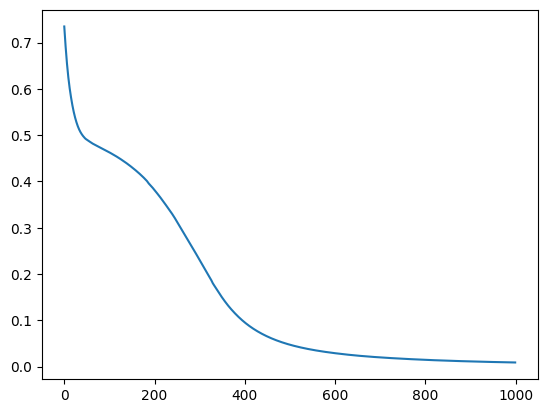

In [54]:
plt.plot(loss_record)

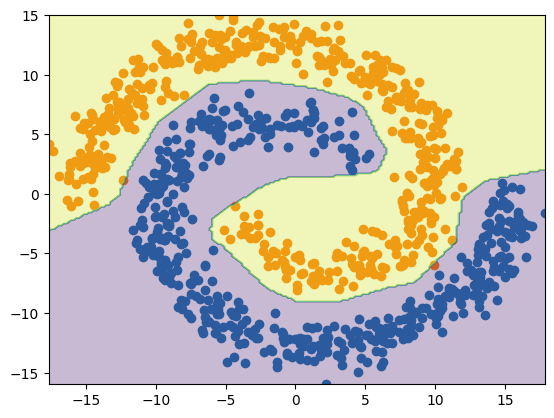

In [55]:
visualize_decision_boundary(model, data, label)

$\sigma(x) = \frac{1}{1+e^{-x}}$

In [41]:
def sigmoid(atensor):
  return 1 / (1 + torch.exp(-atensor))

sigmoid(logit)[:10]

tensor([[0.5561],
        [0.5591],
        [0.5558],
        [0.5591],
        [0.5559],
        [0.5541],
        [0.5564],
        [0.5544],
        [0.5591],
        [0.5591]], grad_fn=<SliceBackward0>)

## 4. Using Different Loss
- Binary Cross Entropy
  - Cross Entropy measures the average number of bits (amount of information) needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution $q$, rather than the true distribution $p$
    - If the two distributions are same, the cross entropy becomes the minimum value, original entropy
      - In supervised-learning such as classification task, the original entropy is zero, so minimum cross entropy is zero

    - If the two distributions are different, the cross entropy becomes larger
  - Binary cross entropy compares when there is only one probability on binary class.
  - $L = -\frac{1}{N}\sum_{n=1}^N y_n\log(\hat{y}_n) + (1-y_n)\log(1-\hat{y}_n)$
    - $y_n$: true label
    - $\hat{y}_n$: predicted label

  - $\hat{y}$ is usually output of sigmoid function
  - sigmoid function: $y = \frac{1}{1+e^{-x}}$


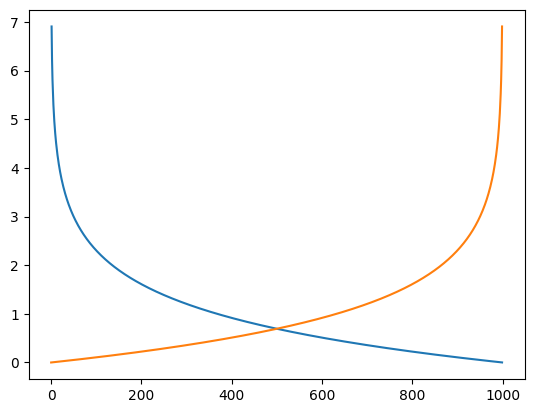

In [16]:
dummy_x = torch.arange(1000) / 1000
negative_log_x = -torch.log(dummy_x)
negative_log_1_minus_x = -torch.log(1-dummy_x)

plt.plot(negative_log_x)
plt.plot(negative_log_1_minus_x)

  - $L = -\frac{1}{N}\sum_{n=1}^N y_n\log(\hat{y}_n) + (1-y_n)\log(1-\hat{y}_n)$


In [70]:
def get_binary_cross_entropy(pred, target): #BCE function
  # implement it with for loop
  # num_samples = len(pred)
  # loss = 0
  # for n in range(num_samples):
  #   y = target[n]
  #   y_hat = pred[n]
  #   loss += -(y*y_hat.log() + (1-y)*(1-y_hat).log())
  # loss /= num_samples

  # implement with vectorization
  return -torch.mean(target * (pred+1e-8).log() + (1-target) * (1-pred+1e-8).log())

import time

start_time = time.time()
for _ in range(100):
  get_binary_cross_entropy(prob, label)
end_time = time.time()
print(end_time - start_time)

RuntimeError: The size of tensor a (1000) must match the size of tensor b (400) at non-singleton dimension 0

## NN can memorize everything!

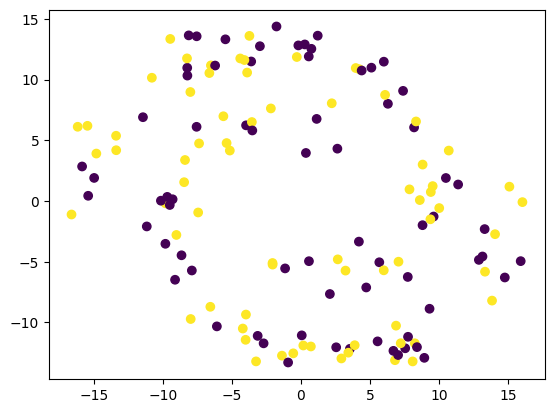

In [87]:

# make spiral data
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 50
noise_weight = 3.0

def create_spiral_dataset(N, noise_weight):

  theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  data_a = data_a + np.random.randn(N,2) * noise_weight

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  data_b = data_b + np.random.randn(N,2) * noise_weight

  data = np.append(data_a, data_b, axis=0)
  label = np.append(np.zeros(N), np.ones(N))

  randomize_order = np.random.permutation(len(data))
  data = data[randomize_order] # shuffle

  randomize_order = np.random.permutation(len(data))
  label = label[randomize_order] # shuffle label with different order

  data = torch.from_numpy(data).float()
  label = torch.from_numpy(label).float().unsqueeze(1)

  return data, label

train_data, train_label = create_spiral_dataset(70, 1.0)
test_data, test_label = create_spiral_dataset(100, 2.0)

# test_data = torch.from_numpy(data).float()
# test_label = torch.from_numpy(label).float().unsqueeze(1)


# print(test_data.shape, test_label.shape)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)
# plt.scatter(test_data[:,0], test_data[:,1], c='red')

In [88]:
# tqdm helps to visualize the progress bar in iteration
from tqdm.auto import tqdm

model = Classifier(hidden_size=512)
optimizer = torch.optim.Adam(model.parameters())

num_iter = 2000
loss_record = []

for iter in tqdm(range(num_iter)):
  logit = model(train_data) # logit is value before sigmoid
  prob = logit.sigmoid()
  # loss = (prob - label) ** 2 # square error
  # loss = loss.mean()
  loss = get_binary_cross_entropy(prob, train_label)
  loss.backward() # backpropagation: make the gradient
  optimizer.step() # update parameters
  optimizer.zero_grad() # reset the gradient
  loss_record.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

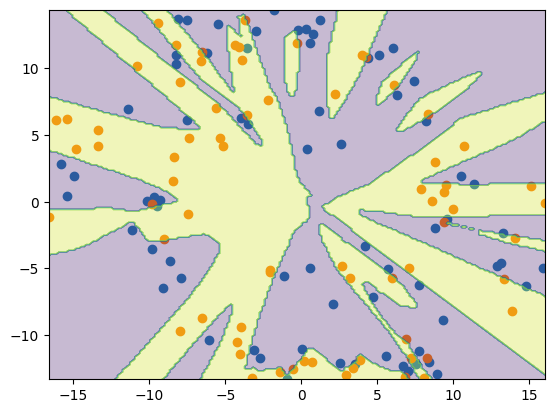

In [90]:
visualize_decision_boundary(model, train_data, train_label)

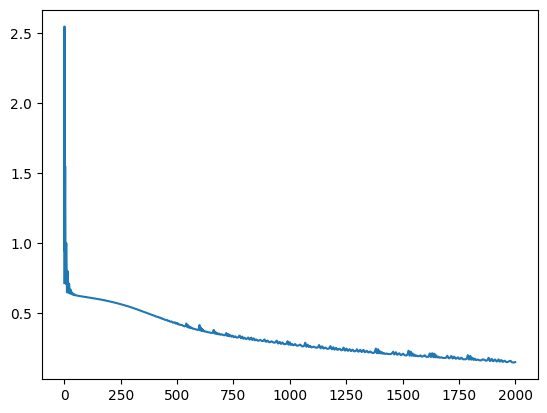

In [91]:
plt.plot(loss_record)

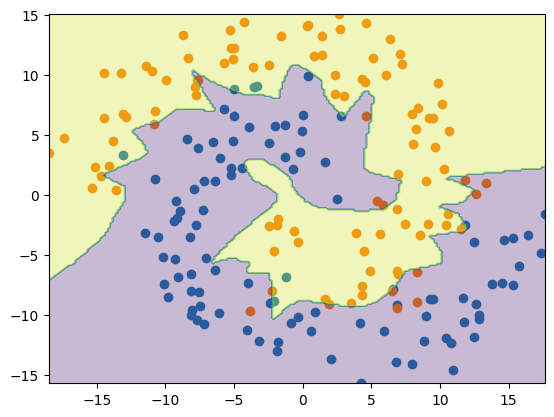

In [82]:
# example of overfitting
visualize_decision_boundary(model, test_data, test_label)

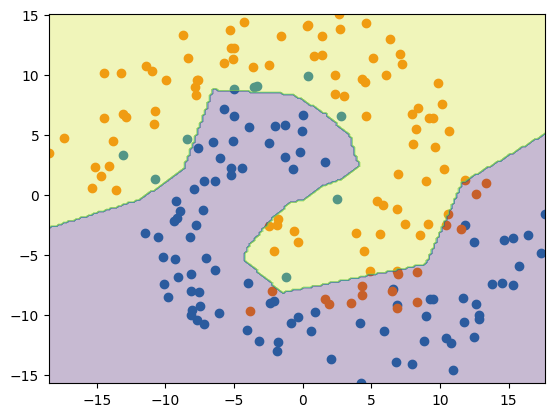

In [79]:
# example of underfitting
visualize_decision_boundary(model, test_data, test_label)